# Description
In this notebook we will try to figure out the feasibility of the final step of the project.  To do this, we will (perhaps arbitrarily) choose a Lagrangian and write the Fokker-Planck equation associated to the Euler-Lagrange equations + noise.  Then we will code it using a Hermite basis.

##Our Lagrangian
Let let $Q = \mathbb{R}^2$.  For each $N \in \mathbb{N}$ we can consider the Lagrangian $L_N \in C^1(TQ)$ given by
$$L_N(q,v) = \frac{1}{2} \| v \|^2 - U_N(q)$$
where $q = (x,y)$ and $U_N(x,y) = \sum^{N,N}_{ k_x =0, k_y =0} \frac{1}{k_x k_y} H_{k_x}(x) H_{k_y}(y)$

##The Euler-Lagrange equations (+noise)
The stochastic Euler-Lagrange equation is
$$ dq = v dt \quad , \quad dv = - \nabla U_N(q)dt + \sigma^2 dW $$
This is just the standard Euler-Lagrange equation with a random force term given by white noise.
The term $\nabla U_N(q)$ can be written explicitly as
$$ \partial_x U_N(q) = \sum_{k_x,k_y} \frac{1}{k_x k_y} H'_{k_x} (x) H_{k_y} (y)$$


##The Fokker-Planck equation and the Shrodinger equation
The Fokker-Planck equation is
$$
    \partial_t \rho + \mathcal{L}_X[\rho] + \sigma^2 \Delta_{v} \rho = 0
$$
where $\Delta_v = -\partial_{v_x}^2 - \partial_{v_y}^2$ and $\mathcal{L}_X[\rho]$ is the Lie-derivative operator
$$
    \mathcal{L}_X[\rho] = v_x \partial_x \rho + v_y \partial_y \rho - \partial_x U_N \cdot \partial_{v_x} \rho - \partial_y U_N \cdot \partial_{v_y} \rho.
$$
The gradients of $U$ can be more explicitly written as
$$
    \partial_x U_n = \sum_{k_x=0,k_y=0}^{N,N} H_{k_x}'(x) H_{k_y}(y) = \sum_{k_x=1,k_y=0}^{N,N} 2k_x H_{k_x-1}(x) H_{k_y}(y) 
$$

Alternatively, if $\rho = |\psi|^2$ then
$$
    \partial_t \psi + \mathcal{L}_X[\psi] + \sigma i \nabla \psi = 0
$$
where $\mathcal{L}_{X}[\psi]$ is the Lie derivative for a half-density and $i\nabla$ is a Dirac operator.  However, this formulation provides little benefit in our scenario, since the vector-field is incompressible.

**TODO:  Is it $\sigma$ or $\sigma^2$?:**


#Hermite functions
We use the Hermite functions
$$
    h_n(x) = c_n e^{-x^2 / 2 \sigma^2} H_n(x)
$$
where $c_n = \pi^{-1/4} (2^n n!)^{-1/2}$ and $H_n(x)$ is the $n$th (physicist's) Hermite polynomial generated via
$$
    H_{n+1}(x) = 2x H_{n}(x) - 2n H_{n-1}(x) 
$$
with $H_0(x)= 1$ and $H_1(x) = x$.

###Generator
The hermite functions are generated by the formula
$$
    h_n(x) = \sqrt{\frac{2}{n}} x h_{n-1}(x) - \sqrt{ \frac{n-1}{n} } h_{n-2}(x)
$$

##Hermite function interpolation in one dimension
Now that we have the Hermite functions working, let's see if we can do one-dimensional interpolation.
Start by assuming $f(x) = \sum_n a_n h_n( \alpha x )$.
We desire to calculate the coefficients, $a_n$.
First note that if $\{ \gamma_0,\dots,\gamma_N\}$ are the Gaussian quadrature nodes,
then $\{ h_0,\dots, h_N\}$ satisfies the orthgonality condition
\begin{align}
    \sum_{i=0}^N h_m(\gamma_i) h_n(\gamma_i) C_i = \int h_m(x) h_n(x) dx = \delta_{mn} 
\end{align}
for some set of weights $C_i$, courtesy of Gaussian quadrature.
Thus $Q^T_{ni} = h_{n}(\gamma_i)/ \sqrt{C_i}$ is an orthogonal matrix.
This implies that the sum (obtained by transposition) satisfies an orthogonality relation
\begin{align}
    \sum_{n=0}^N h_n(\gamma_i) h_n(\gamma_j) = C_i \delta_{ij}
\end{align}
where $C_i = \sum_{n} (h_n(\gamma_i))^2$.

In other words, the matrix
$
    Q_{ni} = h_n(\gamma_i) / C_i^{1/2}
$
is an orthogonal matrix.
We can write $f(\gamma_i/\alpha) = \sum_n a_n h_n(\gamma_i) = \sum_n a_n Q_{ni} C_i^{1/2}$.
Rearranging we get $f(\gamma_i / \alpha) / C_i^{1/2} = a_n Q_{ni}$.
We can invert $Q$ by transposing it, to find $Q_{ni} f(\gamma_i  / \alpha ) / C_i^{1/2} = a_n$.
This yeilds
$$
    a_n = \sum_i h_n(\gamma_i) f(\gamma_i / \alpha) / C_i
$$
This is formula (2.11) of Tang 1993.

## 2D interpolation and higher
We take tensor products of the concepts in the one-dimensional case in order to deal with the two-dimensional case.
So
\begin{align}
    f( x / \alpha , y/\alpha) = \sum_{n_1 , n_2} a_{n_1,n_2} h_{n_1}(x) h_{n_2}(y)
\end{align}
and the relevant orthgonality condition is
\begin{align}
    \sum_{n_1,n_2=0}^N h_{n_1}( \gamma_{i_1}) h_{n_2}( \gamma_{i_2}) h_{n_1}( \gamma_{j_1}) h_{n_2}( \gamma_{j_2}) 
    = C_{i_1} C_{i_2} \delta_{i_1 j_1} \delta_{i_2 j_2}
\end{align}
So that $Q_{ni} = ( h_{n_1}( \gamma_{i_1} )/C_{i_1}^{1/2} ) ( h_{n_2}( \gamma_{i_2}) / C_{i_2}^{1/2})$ is an orthogonal matrix.

Proceeding as before, if we evaluate $f$ on the nodes we find
\begin{align}
    f \left( \frac{ \gamma_{i_1} }{ \alpha} , \frac{ \gamma_{i_2} }{ \alpha } \right) &=
    \sum_{n_1 , n_2} a_{n_1,n_2} h_{n_1}( \gamma_{i_1} ) h_{n_2}( \gamma_{i_2} ) \\
    &= \sum_{n_1 , n_2} a_{n_1,n_2} Q_{ni} C_{i_1}^{1/2} C_{i_2}^{1/2}
\end{align}
By virtually, the same math as before we use the orthogonality of $Q$ to obtain
\begin{align}
    a_n = \sum_{i_1,i_2} h_{n_1}(\gamma_{i_1}) h_{n_2}(\gamma_{i_2})
    C^{-1}_{i_1} C^{-1}_{i_2}
    f \left( \frac{ \gamma_{i_1} }{ \alpha} , \frac{ \gamma_{i_2} }{ \alpha } \right).
\end{align}
From this excercise we can see that generally for $f$ a function in $\mathbb{R}^n$ that
\begin{align}
    f( \mathbf{x} / \alpha ) = \sum_{ \mathbf{n} } a_{\mathbf{n}} h_{\mathbf{n}}( \mathbf{x}  )
\end{align}
then
\begin{align*}
    a_{\mathbf{n}} = \sum_{\mathbf{i}} h_{\mathbf{n}}( \gamma_{\mathbf{i}}) C^{-1}_{\mathbf{i}} f( \gamma_{\mathbf{i}} / \alpha )
\end{align*}
where bold math fonts correspond to natural generalization to multi-indices.  In particular
\begin{align*}
    \gamma_{\mathbf{i}} &= ( \gamma_0, \dots, \gamma_N) \\
    h_{\mathbf{n}}( \mathbf{x}) &= \prod_{k=0}^N h_{n_k}( x_k) \\
    C_{\mathbf{i}} &= \prod_{k=0}^N C_{i_k}
\end{align*}


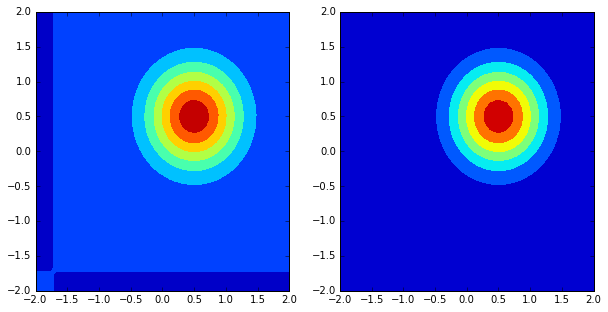

In [2]:
import hermite_function
import numpy as np
hermite_function = reload(hermite_function)
deg = 20
M = 2
h_series = hermite_function.hermite_function_series( dim = 2, deg = deg , M = M )

sigma = 0.5
mu_x = 0.5
mu_y = 0.5
f = lambda x,y: np.exp( - ((x-mu_x)**2 + (y-mu_y)**2) / (2*sigma**2) )
h_series.interpolate_function(f)
f_interpolant = h_series.evaluate_on_uniform_grid( res = 50 )
x_grid,y_grid = h_series.get_uniform_grid( res=50)
from matplotlib import pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(1,2, figsize = (10,5))
ax[0].contourf( x_grid, y_grid, f_interpolant )
ax[1].contourf( x_grid, y_grid, f(x_grid,y_grid))

### Important operators
The Hermite functions satisfy
$$
    h'_n(x) = \sqrt{ \frac{n}{2} } h_{n-1}(x) - \sqrt{ \frac{n+1}{2} } h_{n+1}(x)
$$
and
$$
    x h_n(x) = \sqrt{ \frac{n}{2} } h_{n-1}(x) + \sqrt{ \frac{n+1}{2} } h_{n+1}(x)
$$
which are sparse operations in this basis, so that polynomial vector fields with only a few terms are just compositions of sparse operators.
We should note that we are more concerned with applying the operators $\frac{d}{dx}$ and $x$ to $h(\alpha x)$.
So we should keep the chaing rule in mind (i.e. $\frac{d}{dx} h(\alpha x) = \alpha h'(x)$ and $x h(\alpha x) = \alpha^{-1} ( \alpha x \cdot h(\alpha x) )$.

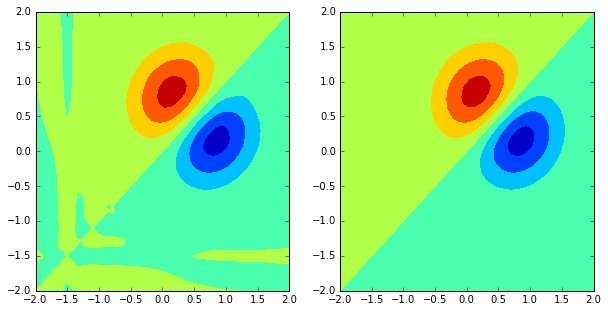

In [2]:
import hermite_function
df_dx = lambda x,y: (x-mu_x)*np.exp( -((x-mu_x)**2 +(y-mu_y)**2)/ (2*sigma**2) ) / sigma**2
df_dy = lambda x,y: (y-mu_y)*np.exp( -((x-mu_x)**2 +(y-mu_y)**2)/ (2*sigma**2) ) / sigma**2
test = lambda x,y: -y*df_dx(x,y) + x*df_dy(x,y)
p_x = np.zeros((2,2))
p_x[0,1] = -1.0
p_y = np.zeros((2,2))
p_y[1,0] = 1.0
polynomials = [ p_x , p_y]
L_f = hermite_function.Lie_derivative( polynomials=polynomials, M=M, deg=deg , dim = 2)
dh_series = L_f.dot( h_series )
dh_grid = dh_series.evaluate_on_uniform_grid( res = 50 )
x_grid,y_grid = dh_series.get_uniform_grid( res=50)
figs,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].contourf( x_grid, y_grid, dh_grid )
ax[1].contourf( x_grid, y_grid, test(x_grid,y_grid))

##Horner's algorithm
Horner's algorithm starts by considering the polynomial
$$
    p(x) = a_0 + a_1 x + \cdots + a_n x^n
$$
and evaluates it in $O(n)$ time by computing it in the order suggested by the parenthesis below
$$
    p(x) = a_0 + x(a_1 + x(a_2 + x( \cdots (a_{n-1} + x a_n) \cdots ) ) )
$$
Which suggests the algorithm:

In [3]:
def horners( a , x ):
    n = a.size
    b = a[n-1]
    for k in range(n-2,-1,-1):
        b = a[k] + b*x
    return b

In multiple dimensions we consider polynomials of the form
$$
    p(x_1,\dots,x_d) = \sum_{k_1,\dots,k_d} a_{k_1,\dots,k_d} \prod_{i=1}^{d} x_i^{k_i}
$$
To evaluate this polynomial use the decomposition
$$
    p(x_1,\dots,x_d) = \sum_{k_1} p_{k_1}(x_2,\dots,x_d) x_1^{k_1}
$$
where $p_{k_1}( x_2 , \dots, x_d) = \sum_{k_2,\dots,k_d} a_{k_1,k_2,\dots,k_d} x_2^{k_2} \cdots x_d^{k_d}$.
Given the values of $p_{k_1}(x_2,\dots,x_d)$ for each $k_1$ we can evaluate $p(x_1,\dots,x_d)$ using Horner's algorithm.
Thus we've reduced our $d$-dimensional problem in to a $d-1$ dimensional problem.
In the base case, $d=1$, we just use Horner's algorithm directly.

In [4]:
def eval_ndpoly( a , x):
    n = a.shape[0]
    b = 0.
    if len(a.shape) > 1:
        for k in range(n-1,-1,-1):
            A = eval_ndpoly( a[k,:] , x[1:len(x)])
            b = A + x[0]*b
        return b
    return horners(a,x[0])
        
a = np.zeros( (3,3,3) )
a[1,1,1] = 1.0
a[0,2,2] = 2.0
x = np.random.randn(3)
print eval_ndpoly(a,x)
print x[0]*x[1]*x[2] + 2.0 * x[1]**2 * x[2]**2

9.64973543679e-05
9.64973543679e-05


## Test:  Van der pol Oscillator
Let's test on the dynamics of the Vanderpol oscillator
$$
    \dot{x} = y \\
    \dot{y} = \mu( 1- x^2) y -x
$$

In this case the Louiville equation is
$$
    \partial_t \rho + \partial_x ( y \cdot \rho ) + \partial_y ( [\mu (1-x^2)y - x] \cdot \rho) = 0.
$$

Note:  The current code integrates this Louiville equation directly.  The results are mediocre.  They were vastly improved when I used the half-density formulation.  However, the half-density formulation does not handle noise (still don't know how to do this).


In [5]:
p_x = np.zeros( (2,2) )
p_y = np.zeros( (3,3) )

mu = 1.0
p_x[0,1]= 1.
p_y[0,1]= mu
p_y[1,0]= -1.
p_y[2,1]= -mu
polynomials = [p_x,p_y]
M=3
deg=50

sigma = 0.5
mu_x = 0.0
mu_y = 0.0
f = lambda x,y: np.exp( - ((x-mu_x)**2 + (y-mu_y)**2) / (2*sigma**2) )
h_series = hermite_function.hermite_function_series(M=M,deg=deg, dim=2)
h_series.interpolate_function(f)
L_f = hermite_function.Lie_derivative( polynomials=polynomials, M=M, deg=deg , dim = 2)

In [6]:
from scipy.integrate import odeint
x0 = h_series.coeffs.flatten()
ode_func = lambda x,t: L_f.op.dot(x)
t = np.linspace(0,1,20)
x = odeint( ode_func , x0 , t )


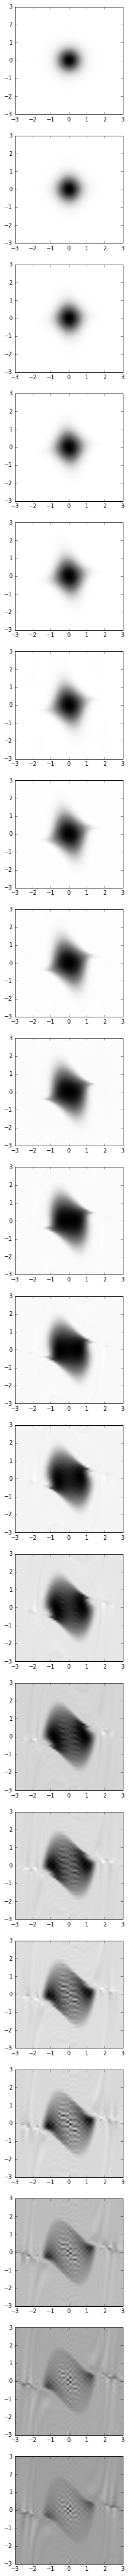

In [7]:
fig,ax = plt.subplots( len(x),1 , figsize=(4,len(x)*4))
hermite_function = reload(hermite_function)
for i in range(len(x)):
    new_h_series = hermite_function.hermite_function_series( coeffs=x[i].reshape((deg+2,deg+2)) , dim=2,M=M,deg=deg)
    z_grid = new_h_series.evaluate_on_uniform_grid(res=50)
    ax[i].imshow(z_grid, extent=[-M,M,-M,M], cmap='Greys')

##Test: Brownian motion
In order to add noise we must consider SDEs such as
$$
    dx = v(x) dt + \sigma^2 dW
$$
We desire to solve the Fokker-Planck equation
$$
    \partial_t \rho + \partial_i ( v^i \rho ) = \sigma^2 \Delta \rho
$$
In this case there is no corresponding Shrodinger equation.  We can consider the quantum Louiville equation
$$
    \partial_t \hat{\rho} + [\mathcal{L}_v , \rho ] + \sigma^2 [\Delta , \rho ] = 0,
$$
but this is not practical, as the discretization involves density matrices and scales terribly with dimension.  Perhaps we should just drop the whole half-density thing and just do a standard spectral method.


In [8]:
p_x = np.zeros( (2,2) )
p_y = np.zeros( (3,3) )

polynomials = [p_x,p_y]

M=3
deg=50
hermite_function = reload( hermite_function )
sigma = 0.5
mu_x = 0.0
mu_y = 0.0
f = lambda x,y: np.exp( - ((x-mu_x)**2 + (y-mu_y)**2) / (2*sigma**2) )
h_series = hermite_function.hermite_function_series(M=M,deg=deg, dim=2)
h_series.interpolate_function(f)
L_f = hermite_function.Lie_derivative( polynomials = polynomials, dim =2, M=M, deg=deg , sigma = 0.5 )

In [9]:
from scipy.integrate import odeint
x0 = h_series.coeffs.flatten()
ode_func = lambda x,t: L_f.op.dot(x)
t = np.linspace(0,1,20)
x = odeint( ode_func , x0 , t )

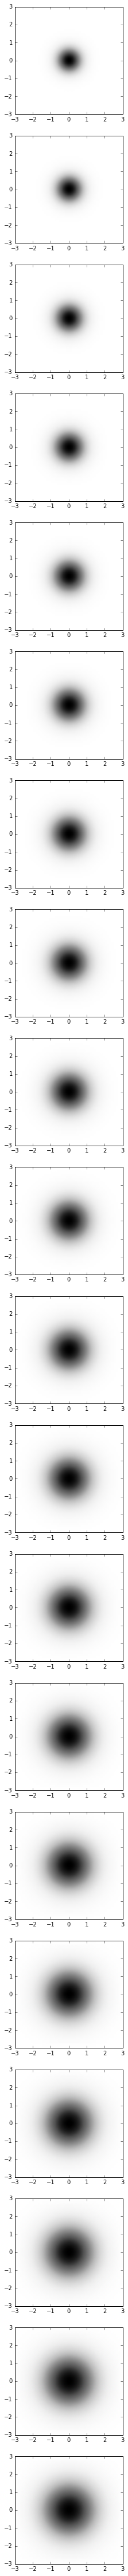

In [10]:
fig,ax = plt.subplots( len(x),1 , figsize=(4,len(x)*4))
hermite_function = reload(hermite_function)
for i in range(len(x)):
    new_h_series = hermite_function.hermite_function_series( coeffs=x[i] , dim=2,M=M,deg=deg)
    z_grid = new_h_series.evaluate_on_uniform_grid(res=50)
    ax[i].imshow(z_grid, extent=[-M,M,-M,M], cmap='Greys')

##Test: Van der Pol + Noise
Now we consider the Fokker-Plank equation where $v(x)$ is the Van der Pol vector field.

In [11]:
p_x = np.zeros( (2,2) )
p_y = np.zeros( (3,3) )

mu = 1.0
p_x[0,1]= 1.
p_y[0,1]= mu
p_y[1,0]= -1.
p_y[2,1]= -mu
polynomials = [p_x,p_y]

M=4
deg=20
hermite_function = reload( hermite_function )
sigma = 0.5
mu_x = 0.0
mu_y = 0.0
f = lambda x,y: np.exp( - ((x-mu_x)**2 + (y-mu_y)**2) / (2*sigma**2) )
h_series = hermite_function.hermite_function_series(M=M,deg=deg, dim=2)
h_series.interpolate_function(f)
L_f = hermite_function.Lie_derivative( polynomials = polynomials, dim =2, M=M, deg=deg , sigma = 0.5 )

from scipy.integrate import odeint
x0 = h_series.coeffs.flatten()
ode_func = lambda x,t: L_f.op.dot(x)
t = np.linspace(0,1,20)
x = odeint( ode_func , x0 , t )

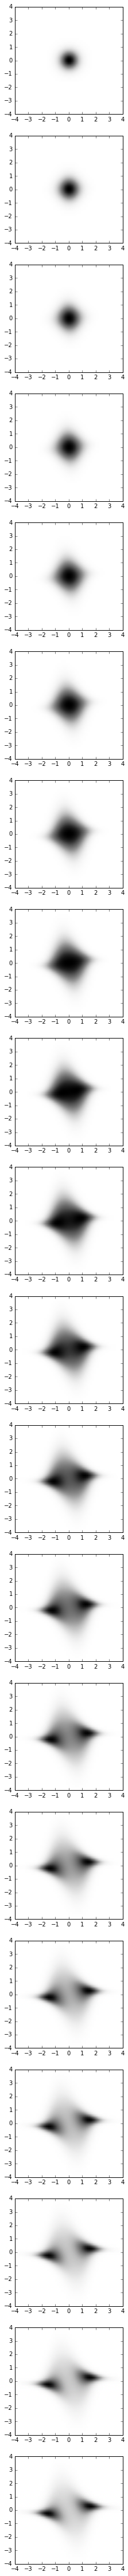

In [12]:
fig,ax = plt.subplots( len(x),1 , figsize=(4,len(x)*4))
hermite_function = reload(hermite_function)
for i in range(len(x)):
    new_h_series = hermite_function.hermite_function_series( coeffs=x[i] , dim=2,M=M,deg=deg)
    z_grid = new_h_series.evaluate_on_uniform_grid(res=50)
    ax[i].imshow(z_grid, extent=[-M,M,-M,M], cmap='Greys')

##Test: A simple Lagrangian
Let's consider a double well Lagrangian
$$
    L(x,y,u,v) = \frac{1}{2}( u^2 + v^2 ) - V(x,y)
$$
with the potential function
$$
    V(x,y) = y^2( x^4 - x^2 )
$$
The Euler-Lagrange equations are
\begin{align}
    \dot{x} &= u \\
    \dot{y} &= v \\
    \dot{u} &= - y^2( 4x^3 - 2x ) \\
    \dot{v} &= - 2y(x^4 - x^2)
\end{align}

In [22]:
hermite_function = reload(hermite_function)
p_x = np.zeros( (1,1,2,1) )
p_y = np.zeros( (1,1,1,2) )
p_u = np.zeros( (4,3,1,1) )
p_v = np.zeros( (5,2,1,1) )

p_x[0,0,1,0]= 1.
p_y[0,0,0,1]= 1.
p_u[3,2,0,0]= -4.
p_v[4,1,0,0]= -2.
polynomials = [p_x,p_y,p_u,p_v]
M=3

deg=11

sigma = 1.0
mu_x = 0.0
mu_y = 0.0
mu_u = 0.0
mu_v = 0.0
G = lambda x,mu,s : np.exp( - (x-mu)**2 / (2*s**2) )
f = lambda x,y,u,v: G(x,mu_x,sigma)*G(y,mu_y,sigma)*G(u,mu_u,sigma)*G(v,mu_v,sigma)
h_series = hermite_function.hermite_function_series(M=M,deg=deg, dim=4)
h_series.interpolate_function(f)
L_f = hermite_function.Lie_derivative( polynomials=polynomials, M=M, deg=deg , dim = 4)

In [23]:
from time import time
t0 = time()
print type(h_series)
new_h_series = L_f.dot( h_series )
print time()-t0


<type 'instance'>
0.00212693214417


For `deg`=10 we found the total time to compute one time-step was 0.0015 seconds.  This suggests about 

## Scaling with resulution
Let us consider the Lagrangian above and see how long it takes to compute a single Euler-step as degree varies.

In [18]:
data = np.load('scaling_by_degree_data.npz')
t_arr = data['arr_0']
deg_arr = data['arr_1'] 

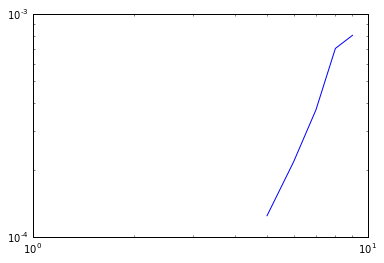

In [22]:
plt.loglog( deg_arr, t_arr)
plt.grid(True)

##Scaling with the numer of terms
Lets consider a sequence of Lagrangian, each with an additional term.  To do this, we can use the fact that we can add Lie-derivative operators.

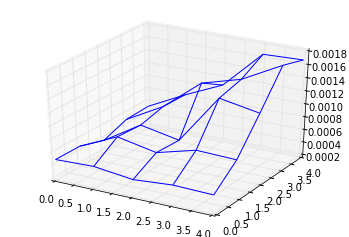

In [12]:
times = np.load('CPU_vs_n_terms_data.npy')
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
X_grid,Y_grid = np.meshgrid( np.arange(0,times.shape[0]) , np.arange(0,times.shape[1]))
ax.plot_wireframe(X_grid,Y_grid,times)